# Building a convnet for ✊✋✌
This presents how to build a convnet from scratch to classify images of rock-paper-scissors.  It is meant as a teaching activity to demonstrate the following concepts in practice:
- how images are represented and handled in software
- how to prepare a machine learning dataset
- how a full machine learning pipeline looks
- data preprocessing
- data augmentation and its importance in a 
- overfitting, underfitting

We use the high-level deep learning library Keras, but the concepts are general and we don't put much focus on the specifics of the code.

## Step 0: defining the problem
What problem do we want to solve, exactly?  We want to build a piece of software that, given an image as input that represents an hand making one of the three ✊✋✌ gestures, produces as output a classification of the image in one of the three classes.

In the following, we will adopt this convention
- class 0 is ✊ rock
- class 1 is ✋ paper
- class 2 is ✌ scissors

## Step 1: building a dataset
We are starting from scratch, so we need to shoot our own dataset; the best option is that multiple students/groups shoot plenty of images in parallel and then the data is somehow collected.  Whatever the process, in the end we want to have all pics in three different directories, one per class.  Format can be either jpg or png, and landscape/portrait, aspect ratio and resolution don't matter and can be mixed.

With some attention to logistics, this can be done in about 10-30 minutes.

Guidelines for shooting images. 
- We don't need high resolution: use the lowest resolution/quality allowed by the phone (this reduces the size of the dataset and speeds up data transfer).
- The hand must be more or less in the center of the image; it should not fill the whole image, but it should not be too small either.  ![caption](figures/guidelines.jpg)
- we want the dataset to represent as much variability as possible: if we want the classifier to work for all hand orientations, try to have examples for all of them; if we want to handle many different lightling conditions, try to have some pictures for different lightings;
- avoid poses that are ambiguous, unless you want to make your job harder: e.g., don't include in the dataset images of paper or scissors taken from the side;
- avoid having two images in the dataset that are almost the same: change the camera and hand pose at least a little bit; this is important because in the following code we randomly split training and testing data.

Remember that we need the images for each class to be in its own directory. To make this simpler, it helps to shoot first all images of rock, then all images of paper, then all images of scissors, and finally sort the images by time in the file manager and group them accordingly.

Place all images in three directories named `c0/`, `c1/`, and `c2/`.  Make sure that each directory only contains image files.

## Step 2: read in images and have a look at them
Let's first import what we need

In [3]:
%matplotlib nbagg

# General imports
import matplotlib.pyplot as plt
import pathlib
import skimage
import skimage.transform
import skimage.viewer
import pandas as pd
import numpy as np
import time
import keras.utils.np_utils

# Setup to show interactive jupyter widgets
from IPython.display import Image, display
from ipywidgets import interact, fixed
import ipywidgets as widgets
def imgplotList(i,data):
    plt.figure(figsize=(10,10))
    plt.imshow(data[i],interpolation="nearest")
    plt.show()

In [10]:
# Define where datasets are located
dataset_directory = pathlib.Path(".")/"datasets"/"final split"

# Define which datasets we should consider.
# Each dataset is a directory withing dataset_directory
# and must contain three subdirectories: (c0, c1, c2) for (rock, paper, scissors).
dnames = [#"D1","D2","D3","D4","D5",
          "D6","testing"]

# Now check the data
ddirs=[dataset_directory/dn for dn in dnames] # directories of the dataset
cdirs={}
for ddir in ddirs:
    cdirs.update({ddir/"c0":0,
                  ddir/"c1":1,
                  ddir/"c2":2})
names = ["rock", "paper", "scissors"]
for cdir,cdir_class in cdirs.items():
    assert(cdir.exists())
    print("Found directory {} containing class {}".format(cdir,names[cdir_class]))

Found directory datasets/final split/D6/c0 containing class rock
Found directory datasets/final split/D6/c1 containing class paper
Found directory datasets/final split/D6/c2 containing class scissors
Found directory datasets/final split/testing/c0 containing class rock
Found directory datasets/final split/testing/c1 containing class paper
Found directory datasets/final split/testing/c2 containing class scissors


Let's try to read the first image from the first directory, and visualize it.  Note that the tool allows you to zoom in order to see the individual pixels.

This cell can be safely skipped.

In [7]:
im = skimage.io.imread(list(list(cdirs.keys())[0].glob("*"))[0])
viewer=skimage.viewer.ImageViewer(im)
viewer.show()
# Note: you have to close the window to continue

[]

We now read in all images, cut the central square (with an edge as long as the shorter dimension), and resize it to 500x500 pixels.  Whatever the initial size and orientation of the images, we will end up with a bunch of 500x500 RGB squares in uint8.  These should be small enough that unless the dataset is huge, all should fit in memory.

We make a pandas dataframe with the data, with two columns:
* image: a $500 \times 500 \times 3$ uint8 numpy array
* label: on of 0, 1 or 2
* file: the full path of the image

Note: this step may take a lot of time.

In [17]:
imagesize = 500

dataset=[]

import warnings

from tqdm import tqdm
for cdir,cn in reversed(list(cdirs.items())):
    for f in tqdm(list(cdir.glob("*"))):
        try:
            im=skimage.io.imread(f)
            h,w=im.shape[0:2] # height, width
            sz=min(h,w)
            im=im[(h//2-sz//2):(h//2+sz//2),(w//2-sz//2):(w//2+sz//2),:] # defines the central square        
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                im=skimage.img_as_ubyte(skimage.transform.resize(im,(imagesize,imagesize))) # resize it to 500x500, whatever the original resolution

        except:
            warnings.warn("ignoring "+str(f))
            continue
            
        dataset.append({
            "file":f,
            "label":cn,
            "image":im})
        
print("Done")

100%|██████████| 84/84 [00:18<00:00,  4.56it/s]

Done


We make a pandas dataframe for the dataset, and create a "dn" field containing the name of the dataset from which each image comes (as the name of the directory it was read from).

In [18]:
dataset=pd.DataFrame(dataset)
dataset["dn"]=dataset["file"].apply(lambda x: x.parent.parts[-2])

Here are 10 random rows from that dataset

In [19]:
dataset.sample(n=10)[["image","label","file","dn"]].style

,image,label,file,dn
80,"[[[136 130 114] [134 126 113] [135 129 115] ..., [254 255 255] [255 255 255] [254 255 255]] [[136 130 116] [130 122 109] [134 126 113] ..., [255 255 255] [255 255 255] [254 255 255]] [[133 127 113] [134 128 114] [134 126 113] ..., [255 255 255] [255 255 255] [254 255 255]] ..., [[180 169 149] [170 162 143] [170 159 139] ..., [255 255 241] [255 255 241] [255 255 239]] [[188 177 157] [177 169 150] [174 165 145] ..., [255 255 240] [254 255 240] [254 255 237]] [[190 177 158] [190 177 158] [180 169 151] ..., [208 206 191] [210 208 193] [201 199 183]]]",0,datasets/final split/testing/c0/IMG_2607.JPG,testing
35,"[[[ 82 63 43] [ 87 69 50] [ 96 78 54] ..., [165 139 126] [156 130 115] [151 125 108]] [[ 83 62 43] [ 81 62 47] [ 78 59 44] ..., [161 135 122] [159 133 119] [161 135 120]] [[ 77 60 41] [ 93 75 53] [ 77 59 39] ..., [154 128 115] [148 122 109] [147 121 107]] ..., [[ 17 16 21] [ 19 17 22] [ 12 10 15] ..., [124 75 63] [118 70 59] [109 61 47]] [[ 19 17 22] [ 15 14 20] [ 8 7 12] ..., [134 88 72] [114 68 53] [134 87 71]] [[ 13 11 17] [ 18 17 23] [ 16 15 20] ..., [113 65 46] [120 67 52] [132 84 71]]]",1,datasets/final split/testing/c1/IMG_5779.JPG,testing
154,"[[[ 27 21 23] [ 15 9 11] [ 18 13 16] ..., [ 51 61 71] [ 59 69 79] [ 66 76 88]] [[ 33 26 34] [ 44 38 48] [ 61 60 73] ..., [ 75 84 93] [ 74 83 92] [ 72 82 94]] [[ 89 99 118] [115 123 145] [127 138 160] ..., [ 91 98 107] [ 91 94 103] [ 91 94 107]] ..., [[ 57 66 71] [ 63 70 76] [ 62 70 73] ..., [ 27 10 28] [ 30 13 31] [ 37 20 38]] [[ 56 65 70] [ 62 69 75] [ 61 69 72] ..., [ 30 13 31] [ 30 16 33] [ 32 15 33]] [[ 57 66 71] [ 59 66 72] [ 58 66 69] ..., [ 32 15 33] [ 28 14 31] [ 29 13 31]]]",2,datasets/final split/D6/c2/20180119_100637.jpg,D6
31,"[[[180 214 245] [184 219 250] [184 220 250] ..., [222 216 204] [224 218 206] [221 215 204]] [[183 219 250] [187 223 255] [188 223 255] ..., [231 225 213] [231 225 213] [225 220 208]] [[185 219 249] [188 223 253] [188 223 253] ..., [231 225 213] [230 224 212] [225 219 207]] ..., [[160 197 232] [163 201 237] [164 202 238] ..., [ 18 13 17] [ 18 13 17] [ 16 14 17]] [[162 199 234] [164 202 238] [164 202 238] ..., [ 18 13 17] [ 16 14 17] [ 16 14 17]] [[157 193 228] [162 199 234] [162 199 234] ..., [ 17 12 16] [ 17 15 18] [ 15 13 16]]]",2,datasets/final split/testing/c2/20150314_203700.jpg,testing
298,"[[[172 145 100] [170 143 96] [171 144 97] ..., [118 96 46] [118 96 46] [119 97 47]] [[173 146 99] [173 146 99] [172 146 98] ..., [120 98 48] [120 98 48] [119 97 47]] [[172 145 98] [173 147 99] [171 145 96] ..., [120 98 48] [119 97 47] [119 97 48]] ..., [[170 143 96] [169 142 95] [170 143 96] ..., [114 62 5] [115 59 4] [117 61 5]] [[169 142 95] [169 142 95] [169 142 95] ..., [114 62 5] [116 60 5] [118 63 8]] [[168 141 94] [170 143 96] [169 142 95] ..., [113 61 4] [117 62 6] [116 61 6]]]",1,datasets/final split/D6/c1/IMG_20180119_102155.jpg,D6
10,"[[[ 78 48 40] [ 77 47 39] [ 80 47 40] ..., [126 124 124] [118 114 115] [127 121 123]] [[ 70 40 32] [ 84 54 46] [ 81 48 39] ..., [119 121 118] [116 118 117] [113 117 116]] [[ 77 47 37] [ 77 47 37] [ 75 45 34] ..., [120 122 119] [118 119 116] [117 118 118]] ..., [[165 165 162] [154 154 152] [156 157 155] ..., [183 183 183] [179 179 177] [184 183 181]] [[157 157 155] [163 163 161] [153 154 153] ..., [181 182 181] [179 179 177] [182 181 179]] [[156 158 157] [164 166 165] [156 158 157] ..., [179 180 179] [176 176 174] [179 178 176]]]",2,datasets/final split/testing/c2/IMG_20170315_110018.jpg,testing
232,"[[[103 94 79] [111 102 87] [113 104 89] ..., [ 10 7 12] [ 13 9 14] [ 17 12 17]] [[113 104 89] [107 98 83] [106 97 82] ..., [ 9 4 8] [ 13 8 12] [ 13 8 12]] [[115 106 89] [112 103 88] [110 101 86] ..., [ 12 6 10] [ 11 5 9] [ 10 4 8]] ..., [[ 20 31 35] [ 25 39 42] [ 21 35 38] ..., [ 28 49 52] [ 11 33 36] [ 21 45 47]] [[ 23 37 40] [ 19 33 36] [ 26 40 43] ..., [ 24 45 48] [ 15 36 39] [ 26 50 52]] [[ 28 42 45] [ 14 29 32] [ 28 43 46] ..., [ 26 45 49] [ 24 45 50] [ 22 44 48]]]",2,datasets/final spli

Optionally, we can quickly scroll through the images in our dataset.

This cell can be safely skipped.

In [20]:
viewer=skimage.viewer.CollectionViewer([r[1]["image"] for r in dataset.iterrows()])
viewer.show()


# Note: you have to close the window to continue

[]

## Step 3: Prepare training and testing sets

How should we split training and testing data?  The code below implements a few options (run only one of the cells).

In [21]:
# Option one (easy): use all samples from dataset named "testing"
# which contains some images taken in the same days as D1--D4, but not contained in these dirs.
te_mask = dataset["dn"]=="testing"
dataset_te=dataset[te_mask]

In [ ]:
# Option two (hard): use all samples from dataset named "D5"
te_mask = dataset["dn"]=="D5"
dataset_te=dataset[te_mask]

In [22]:
# In any case, training samples are all other samples
dataset_tr=dataset.loc[dataset.index.difference(dataset_te.index)]

In [23]:
# Print a summary of how many training and testing images we have sampled
import collections
pd.DataFrame(index=[0,1,2],data=collections.OrderedDict((
    ("Class name",           names),
    ("# Training images", dataset_tr["label"].value_counts()),
    ("# Testing images",  dataset_te["label"].value_counts())))).set_index("Class name")

,# Training images,# Testing images
Class name,,
rock,84,33
paper,69,34
scissors,167,33


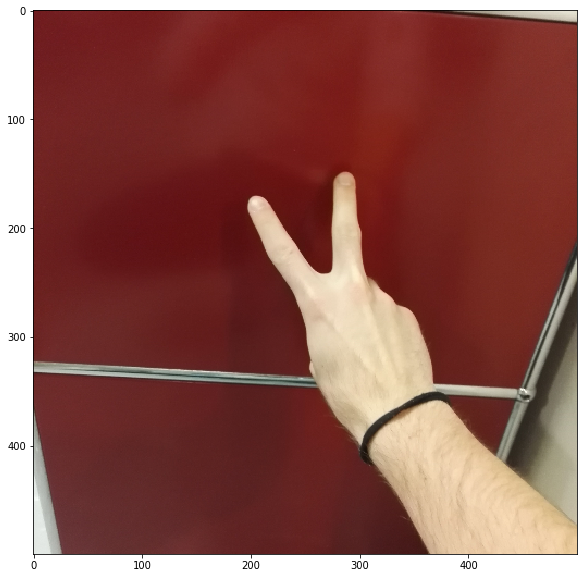

<function __main__.imgplotList>

In [24]:
%matplotlib inline
examples=list(dataset_tr["image"])
interact(
    imgplotList, 
    i=widgets.IntSlider(min=0,max=len(examples)-1, step=1, value=0,continuous_update=False), 
    data=fixed(examples))

## Step 4: define what we feed to the Neural Network

In [37]:
# Take image and resize to a specified size
def transform_simple(im,sz):
    imr = skimage.transform.resize(im, (sz,sz))
    return imr

# Take image and resize to a specified size, after applying data augmentation
def transform_complex(im,sz):
    if(np.random.rand()<0.5):
        im=np.fliplr(im)
    tf1 = skimage.transform.SimilarityTransform(scale = 1 / im.shape[0])
    tf2 = skimage.transform.SimilarityTransform(translation=[-0.5, -0.5])
    tf3 = skimage.transform.SimilarityTransform(rotation=np.deg2rad(np.random.uniform(0,360)))
    tf4 = skimage.transform.SimilarityTransform(scale=np.random.uniform(1,1.6))
    tf5 = skimage.transform.SimilarityTransform(translation=np.array([0.5, 0.5])+np.random.uniform(-0.1,0.1,size=2))
    tf6 = skimage.transform.SimilarityTransform(scale=sz)
    imr = skimage.transform.warp(im, (tf1+(tf2+(tf3+(tf4+(tf5+tf6))))).inverse, output_shape=(sz,sz),mode="edge")
    imr = imr*np.random.uniform(0.9,1.1,size=(1,1,3))
    imr = np.clip(imr,0,1)
    return imr

transform=transform_complex

In [38]:
def sample(df,sz):
    r=df.sample(n=1)
    l=r["label"].iloc[0]
    im=r["image"].iloc[0]
    im=transform(im,sz)
    return im,l

def mktrte(df,N,sz):
    X = []
    y = []
    for i in range(N):
        im,l=sample(df,sz)
        X.append(im)
        y.append(l)
    X=np.array(X).astype('float32')
    y=np.array(y)
    y=keras.utils.np_utils.to_categorical(y,3)
    return X,y

def generator(df,batch_size,sz):
    while True:
        X,y = mktrte(df,batch_size,sz)
        yield (X,y)


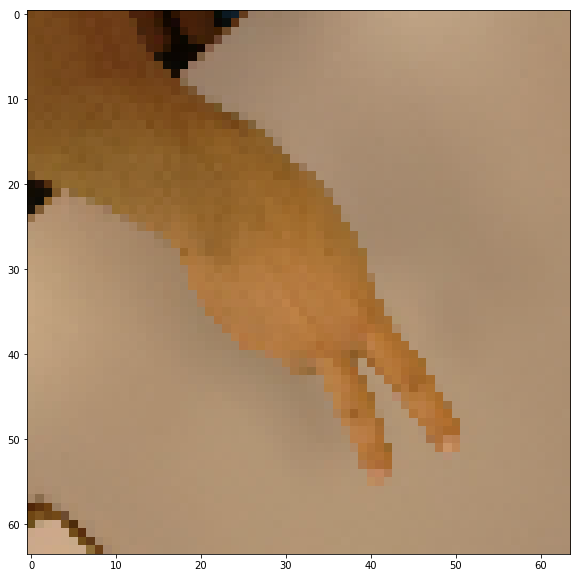

<function __main__.imgplotList>

In [40]:
# Visualize 100 images from our input dataset
examples = list(mktrte(dataset_tr,100,64)[0])
interact(imgplotList, i=widgets.IntSlider(min=0, max=len(examples)-1, step=1, value=0,continuous_update=False), data=fixed(examples))

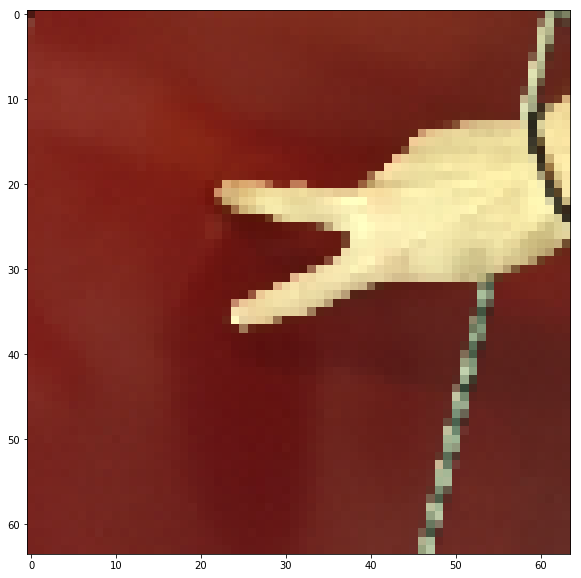

<function __main__.imgplotList>

In [57]:
# Visualize 100 variations from our first input image (makes sense only if transform==transform_complex, i.e. if we are using data augmentation)
examples = list(mktrte(dataset_tr.iloc[[0]],100,64)[0])
interact(imgplotList, i=widgets.IntSlider(min=0, max=len(examples)-1, step=1, value=0,continuous_update=False), data=fixed(examples))

## Step 5: build and train the neural network

In [58]:
# Keras: Deep Learning library for Theano and TensorFlow
import keras
from keras.utils  import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Dropout

# NN settings
patchsize          = 64
batch_size         = 20
nb_filters         = 5     # number of convolutional filters to use
pool_size          = (2,2) # size of pooling area for max pooling
kernel_size        = (3,3) # convolution kernel size

model = Sequential()
model.add(Conv2D(nb_filters, kernel_size, padding='valid', input_shape=(patchsize,patchsize,3))) # 3 perchè rgb
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, kernel_size))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Conv2D(nb_filters, kernel_size))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Conv2D(nb_filters, kernel_size))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Flatten())
model.add(Dense(128)) # generate a fully connected layer wiht 128 outputs (arbitrary value)
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(3)) # output layer
model.add(Activation('softmax')) # output activation per renderle probabilità

## compile! network
model.compile(loss='categorical_crossentropy',
              optimizer="adadelta",
              metrics=['accuracy'])
print(model.count_params())

24385


Build a set of 1000 testing instances taken from the testing dataset.

Note: "testing" is synonym with "validation" and "evaluation"

In [59]:
(X_test,y_test) = mktrte(dataset_te, 1000, patchsize)

# Prepare the logs directory, if it does not exist
(pathlib.Path(".")/"logs").mkdir(exist_ok=True)

While the network trains, we can monitor training loss/accuracy and testing loss/accuracy using tensorboard at http://0.0.0.0:6006

You may need to launch tensorboard first if it's not already running, by executing

`tensorboard --logdir=logs`

in a shell with the current working directory.  Check that you are within the proper conda environment, if applicable.

In [60]:
history=model.fit_generator(
                    generator(dataset_tr, batch_size, patchsize),
                    steps_per_epoch=50, 
                    epochs=5000, 
                    verbose=1,
                    validation_data=(X_test,y_test),
                    callbacks=[keras.callbacks.TensorBoard(log_dir='./logs/'+time.strftime("%Y%m%d%H%M%S"), histogram_freq=0, write_graph=False, write_images=False)])

Epoch 1/5000
50/50 [==============================] - 9s - loss: 1.0439 - acc: 0.5340 - val_loss: 1.2080 - val_acc: 0.3050
Epoch 2/5000
50/50 [==============================] - 8s - loss: 1.0199 - acc: 0.5310 - val_loss: 1.1706 - val_acc: 0.3050
Epoch 3/5000
50/50 [==============================] - 8s - loss: 1.0093 - acc: 0.5410 - val_loss: 1.1851 - val_acc: 0.3050
Epoch 4/5000
50/50 [==============================] - 8s - loss: 1.0198 - acc: 0.5080 - val_loss: 1.1449 - val_acc: 0.3050
Epoch 5/5000
50/50 [==============================] - 8s - loss: 1.0302 - acc: 0.4880 - val_loss: 1.1628 - val_acc: 0.3050
Epoch 6/5000
50/50 [==============================] - 8s - loss: 0.9757 - acc: 0.5230 - val_loss: 1.1139 - val_acc: 0.3190
Epoch 7/5000
50/50 [==============================] - 8s - loss: 0.9819 - acc: 0.5510 - val_loss: 1.1243 - val_acc: 0.3110
Epoch 8/5000
50/50 [==============================] - 8s - loss: 0.9496 - acc: 0.5500 - val_loss: 1.1296 - val_acc: 0.3320
Epoch 9/5000
50/

50/50 [==============================] - 7s - loss: 0.7933 - acc: 0.6490 - val_loss: 1.0584 - val_acc: 0.5020
Epoch 68/5000
50/50 [==============================] - 7s - loss: 0.8013 - acc: 0.6490 - val_loss: 1.0736 - val_acc: 0.4950
Epoch 69/5000
50/50 [==============================] - 7s - loss: 0.8403 - acc: 0.5980 - val_loss: 1.0302 - val_acc: 0.5060
Epoch 70/5000
50/50 [==============================] - 7s - loss: 0.8008 - acc: 0.6510 - val_loss: 1.0540 - val_acc: 0.5070
Epoch 71/5000
50/50 [==============================] - 7s - loss: 0.8023 - acc: 0.6540 - val_loss: 1.1012 - val_acc: 0.4850
Epoch 72/5000
50/50 [==============================] - 7s - loss: 0.7850 - acc: 0.6480 - val_loss: 1.1546 - val_acc: 0.4390
Epoch 73/5000
50/50 [==============================] - 7s - loss: 0.8227 - acc: 0.6470 - val_loss: 1.0572 - val_acc: 0.4910
Epoch 74/5000
50/50 [==============================] - 7s - loss: 0.8096 - acc: 0.6160 - val_loss: 1.1133 - val_acc: 0.4900
Epoch 75/5000
50/50 [=

50/50 [==============================] - 8s - loss: 0.7091 - acc: 0.6910 - val_loss: 1.1697 - val_acc: 0.5070
Epoch 133/5000
50/50 [==============================] - 9s - loss: 0.7098 - acc: 0.6860 - val_loss: 1.2589 - val_acc: 0.4700
Epoch 134/5000
50/50 [==============================] - 8s - loss: 0.7255 - acc: 0.6820 - val_loss: 1.2141 - val_acc: 0.4760
Epoch 135/5000
50/50 [==============================] - 8s - loss: 0.7354 - acc: 0.6810 - val_loss: 1.1847 - val_acc: 0.4910
Epoch 136/5000
50/50 [==============================] - 7s - loss: 0.7311 - acc: 0.6850 - val_loss: 1.2287 - val_acc: 0.4640
Epoch 137/5000
50/50 [==============================] - 7s - loss: 0.6917 - acc: 0.7010 - val_loss: 1.2845 - val_acc: 0.4240
Epoch 138/5000
50/50 [==============================] - 13s - loss: 0.7251 - acc: 0.6810 - val_loss: 1.1861 - val_acc: 0.4780
Epoch 139/5000
50/50 [==============================] - 12s - loss: 0.6813 - acc: 0.7070 - val_loss: 1.2153 - val_acc: 0.4670
Epoch 140/500

50/50 [==============================] - 7s - loss: 0.6645 - acc: 0.7080 - val_loss: 1.2780 - val_acc: 0.4880
Epoch 198/5000
50/50 [==============================] - 7s - loss: 0.6207 - acc: 0.7330 - val_loss: 1.3211 - val_acc: 0.4670
Epoch 199/5000
50/50 [==============================] - 7s - loss: 0.6011 - acc: 0.7430 - val_loss: 1.5003 - val_acc: 0.4660
Epoch 200/5000
50/50 [==============================] - 7s - loss: 0.6404 - acc: 0.7220 - val_loss: 1.3916 - val_acc: 0.4620
Epoch 201/5000
50/50 [==============================] - 7s - loss: 0.6218 - acc: 0.7420 - val_loss: 1.4294 - val_acc: 0.4480
Epoch 202/5000
50/50 [==============================] - 7s - loss: 0.6511 - acc: 0.7100 - val_loss: 1.4658 - val_acc: 0.4510
Epoch 203/5000
50/50 [==============================] - 7s - loss: 0.6353 - acc: 0.7350 - val_loss: 1.4114 - val_acc: 0.4600
Epoch 204/5000
50/50 [==============================] - 7s - loss: 0.6168 - acc: 0.7370 - val_loss: 1.3652 - val_acc: 0.4740
Epoch 205/5000


KeyboardInterrupt: 

After training our model, we can save it to disk

In [ ]:
modelname = "myModel"

# Save model to a file
keras.models.save_model(model,"{}.model".format(modelname))

# Also save the testing dataset (may be large) so we can pick up from here later 
dataset_te.to_pickle("{}.testingdata.pickle".format(modelname))

## Step 6: Process the images of the testing set one by one
And visualize the results

In [ ]:
# Optionally, load a saved model and testing dataset
modelname = "models/model_venus"

model = keras.models.load_model("{}.model".format(modelname))
dataset_te = pd.read_pickle("{}.testingdata.pickle".format(modelname))

In [ ]:
# Show results by processing a single variation of the testing image

%matplotlib inline
def resultsShow(i, data, model):
    d = data.iloc[i]
    im = d["image"]
    l = d["label"]
    fig,axs = plt.subplots(nrows=1,ncols=3,figsize=(15,5),gridspec_kw={'width_ratios':[1,1,0.5]})
    
    imt = transform_simple(im, patchsize)
    axs[0].imshow(im)
    axs[0].set_title("Image (true class: {})".format(names[l]))
    
    axs[1].imshow(imt,interpolation="nearest")
    axs[1].set_title("Network input")
    
    outs = model.predict(np.array([imt]))
    print(outs)
    predicted = np.argmax(outs)
    axs[2].bar(np.array(range(len(names)))-0.5, outs[0,:], 1, color="gray")
    axs[2].set_ylim([0,1])
    axs[2].set_xticks(range(len(names)))
    axs[2].set_xticklabels(names)
    axs[2].set_ylabel("probability")
    axs[2].set_xlabel("class")
    axs[2].set_title("Network output")
    fig.tight_layout()
    plt.show()
    fig.savefig("out_{:05d}_{}.png".format(i,("ok" if predicted==l else "ko")))
    print(outs)

interact(resultsShow, i=widgets.IntSlider(min=0,max=len(dataset_te)-1, step=1, value=0, continuous_update=False), data=fixed(dataset_te.sample(len(dataset_te))), model=fixed(model))


Moreover, we can also visualize the contents of the hidden layers of the NN

In [ ]:
from keras import backend as K

def plot_hidden_layers(imt,nmaps=4):
    fig = plt.figure(figsize=(15, 10))
    plt.title('Hidden layers', loc='center')
    plt.axis('off')
    layers = [model.layers[0].input] + [model.layers[i].output for i in [0,2,5,7,9]]
    for layeri,layer in enumerate(layers):
        get = K.function([model.layers[0].input], [layer])
        layeroutputs = get([imt[np.newaxis,:,:,:]])[0][0]
        for j in range(nmaps): # for each map
            sp2=fig.add_subplot(nmaps,len(layers),layeri+1+j*len(layers))
            sp2.axis('off')
            if (layeroutputs.shape[2]>j):
                vmin,vmax = ((0,1) if layeri == 0 else (-0.3,+0.3))
                sp2.imshow(layeroutputs[:,:,j],
                           cmap="gray",
                           interpolation="nearest")
    fig.tight_layout()

imt=transform(dataset_te["image"].iloc[1],patchsize)
plot_hidden_layers(imt)
